### Robot Learning

### Assignment 5

Solutions are due on 20.05.2025 before the lecture.

### Introduction

Please carefully read the following description of the card game *Blackjack*.

The goal of Blackjack is to draw cards such that their values sum to as close to 21 as possible, but do not exceed 21. All cards 2 through 10 are assigned their number as the respective value, face cards like Jack, Queen and King yield a value of 10 points. The aces are special; they can count as either 1 or 11, depending on what is more beneficial. When using the ace as 11 points does not cause the total value of the hand to exceed 21, the ace is called 'usable'.

The actions are to *stick*, which means to stop drawing cards and let the dealer play, or to *hit*, which means to draw another card to add to your hand.

The opponent is a dealer with a fixed strategy; the dealer will always hit when the dealer's sum of card values is below 17 points. At or above 17 points, the dealer immediately sticks, irrespective of the player's card sum. Note that the dealer only starts playing once the player is finished, so when the player has selected to stick.

The game starts by drawing two cards each to player and dealer from an infinite deck. The player can see the own cards, but only the first card which the dealer recieves, the other is face-down. If the player hits and exceeds 21 points, the player is considered *bust* and immediately loses the game. When the player decides to stick, the dealer will draw cards according to its strategy. If the dealer goes *bust* in the process, the player immediately wins the game. If not, the sum of the dealer's card values is compared to the sum of the player's card values. If they are equal, the game is considered a draw. If the player has a higher score, the player wins, and vice versa.

In this RL setting, the rewards are +1 for winning, -1 for losing, and 0 for drawing and all intermediate moves. The state is a 3-tuple consisting of the players current hand sum, the value of the dealer's initial open card and a boolean describing whether the player currently has a usable ace or not. The action space consists of the integer $0$, which corresponds to *stick*, and the integer $1$, which corresponds to *hit*. Note that this corresponds exactly to the scenario described in *Example 5.1; Reinforcement Learning: An Introduction; Sutton and Barto*.

To get started, please examine the following code cell, which loads the Blackjack environment from the utils file and plays an episode. The player is in this case the random agent. The environment is equivalent to the one provided in OpenAI Gym; we adapted the source code so that installing this python package is not necessary.

In [1]:
import numpy as np
from helpers.utils import BlackjackEnv

np.random.seed(3)
# create a Blackjack environment
casino = BlackjackEnv()

# do this before each new episode
# state is 3-tuple: (player_current_sum, dealer_first_open_card, usable_ace_bool)
# if dealer_first_open_card == 1, the dealer is holding an ace!
starting_state = casino.reset()

# create flag tracking whether the episode is over
done = False

# create lists to save the trajectory and the decisions of the agent
actions, rewards, states = [], [], [starting_state]

# simulate until the episode is over
while not done:
    #in each non-terminal state the agent can either stick (0) or hit (1)
    possibleActions = casino.getAvailableActions()
    # select one of them randomly
    a = np.random.choice(possibleActions).item()
    # save the action
    actions.append(a)
    # execute the action using the step function
    # s is the new state
    # done is the flag whether the episode is over
    # the fourth output _ is a dict containing additional information on the environment
    # it is empty here, but passing it is according to convention in OpenAI Gym environments
    s, r, done, _ = casino.step(action = a)
    # save the states
    rewards.append(r)
    states.append(s)

print('Action Sequence:', actions)
print('Obtained Rewards:', rewards)
print('State Transitions:', states)

Action Sequence: [1, 0]
Obtained Rewards: [0.0, 1.0]
State Transitions: [(17, 9, 1), (21, 9, 1), (21, 9, 1)]


### Task 5.1)

Implement Sarsa($\lambda$) for Blackjack. Use an $\varepsilon$-greedy exploration strategy with $\varepsilon = 0.1$ and a time-varying scalar step-size of $\alpha_t = \frac{1}{N(s_t,a_t)+1}$, where $N(s, a)$ is the number of times the value of this state-action pair has been updated.

Run the algorithm with parameter values $\lambda \in \{0, 0.1, 0.2, \dots, 1\}$. Stop exploration and learning
after $100000$ episodes and plot the average return for the next $10000$ episodes against $\lambda$.

Note that there is a loop over all state-actions pairs in the Sarsa($\lambda$) algorithm. This loop is straightforward (but also necessary) to vectorize. Do not hesitate to contact your tutors if you need help with this step. Also, the random agent scores around $-0.4$ on average, and your trained agents should be able to outperform this weak baseline.

<div style="text-align: right; font-weight:bold"> 5 Points </div>

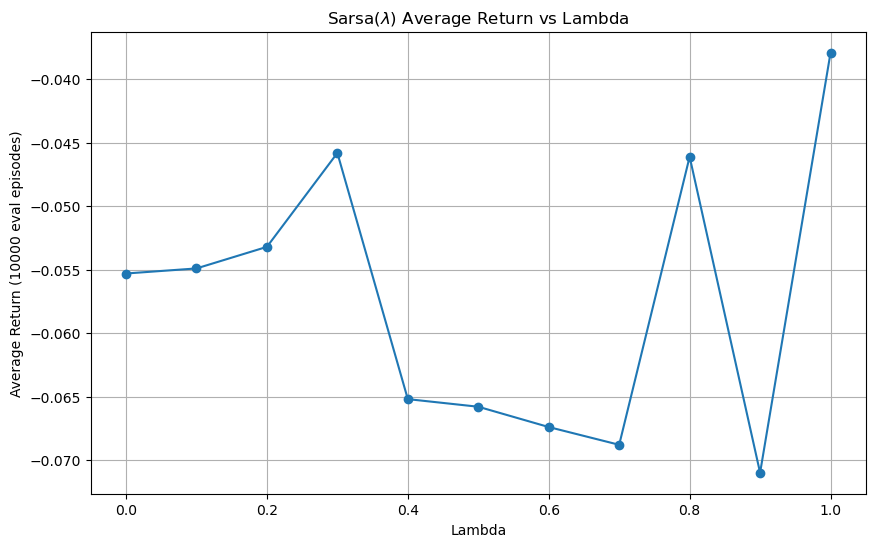

In [2]:
# your code goes here

import matplotlib.pyplot as plt
from collections import defaultdict # for Q and eligibility traces

def epsilon_greedy(Q, state, epsilon=0.1):
    actions = [0, 1]
    if np.random.rand() < epsilon:
        return np.random.choice(actions)
    else:
        return np.argmax([Q[state, a] for a in actions])

# wrt different lamda
def run_sarsa_lambda(lmbda, num_train_episodes, num_eval_episodes, epsilon, gamma):
    env = BlackjackEnv()
    Q = defaultdict(float)
    N = defaultdict(int) # times (s,a) are updated, count alpha

    # training
    for episode in range(num_train_episodes):
        state = env.reset() # reset
        action = epsilon_greedy(Q, state, epsilon)
        E = defaultdict(float)  # eligibility traces
        done = False

        while not done:
            next_state, reward, done, _ = env.step(action)
            # if is not done, take next action by using epsilon greedy
            next_action = epsilon_greedy(Q, next_state, epsilon) if not done else None

            # if is done, target is reward
            # if is not done, target is reward plus next Q
            target = reward if done else reward + gamma * Q[(next_state, next_action)]
            delta = target - Q[(state, action)] # count delta
            E[(state, action)] += 1

            for key in E:
                alpha = 1.0 / (N[key] + 1)
                Q[key] += alpha * delta * E[key] # update all the Q wrt E
                E[key] *= gamma * lmbda
                N[key] += 1

            state = next_state
            action = next_action

    # evaluation
    returns = []
    for _ in range(num_eval_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = np.argmax([Q[(state, a)] for a in [0, 1]]) # use the best strategy
            state, reward, done, _ = env.step(action)
            total_reward += reward
        returns.append(total_reward)
    return Q, np.mean(returns)

Q_final_list = []
avg_returns_list = []

lambdas = np.arange(0, 1.1, 0.1) # different lamda
for lmbda in lambdas:
    Q_final, avg_return = run_sarsa_lambda(lmbda, num_train_episodes=100000, num_eval_episodes=10000, epsilon=0.1, gamma=1.0)
    Q_final_list.append(Q_final)
    avg_returns_list.append(avg_return)

plt.figure(figsize=(10, 6))
plt.plot(lambdas, avg_returns_list, marker='o')
plt.title('Sarsa($\lambda$) Average Return vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Average Return (10000 eval episodes)')
plt.grid(True)
plt.show()

### Task 5.2)

Use your experiment from task 5.1) to select your favorite value for $\lambda$. Learn $Q$ using the Sarsa($\lambda$) algorithm for $1$ million episodes. After training, stop exploration and learning and report the average return for the next $10000$ episodes. Finally, visualize the resulting policy by using the helper function *plotPolicy(Q)*.

<div style="text-align: right; font-weight:bold"> 2 Points </div>

Average return over the next 10000 episodes: -0.0571


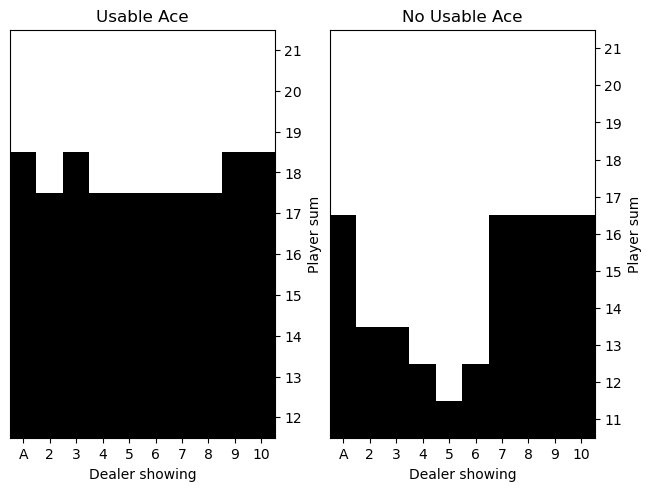

In [7]:
from helpers.utils import plotPolicy
# your code goes here

Q_final, avg_ret = run_sarsa_lambda(lmbda=0.8, num_train_episodes=1000000, num_eval_episodes=10000, epsilon=0.1, gamma=1.0)
Q_array = np.zeros((22, 11, 2, 2))
for (state, action), value in Q_final.items():
    player_sum, dealer_showing, usable_ace = state
    if 0 <= player_sum <= 21 and 1 <= dealer_showing <= 10:
        Q_array[player_sum, dealer_showing, usable_ace, action] = value

print(f"Average return over the next 10000 episodes: {avg_ret:.4f}")
plotPolicy(Q_array)

### Task 5.3)

Now consider a simple coarse coding value function approximator that is based on a binary feature vector $\phi_{s, a} \in \mathbb{R}^{128}$ with $8 \times 4 \times 2 \times 2 = 128$ features. Each binary feature has a value of 1 iff $(s, a)$ lies within the cuboid of state-action-space corresponding to that feature. The cuboids have the following overlapping intervals:

$player(s) = \{[4, 7], [6, 9], [8, 11], [10, 13], [12, 15], [14, 17], [18, 20], [19, 21]\}$

$dealer(s) = \{[1,4], [3, 6], [5, 8], [7, 10]\}$

$usable\_ace(s) = \{0,1\}$

$a = \{0, 1\}$

where

* player(s) is the sum of the player’s cards (4–21) in state s
* dealer(s) is the value of the dealer’s first card (1–10) in state s

Implement a function $phi(s,a)$ which takes a state-action pair $(s,a)$ and maps it to a vector $\phi_{s,a}$ as described above.

<div style="text-align: right; font-weight:bold"> 3 Points </div>

In [6]:
# your code goes here

def phi(s, a):
    player_sum, dealer_showing, usable_ace = s
    feature = np.zeros(128)

    player_ranges = [(4, 7), (6, 9), (8, 11), (10, 13), (12, 15), (14, 17), (18, 20), (19, 21)]
    dealer_ranges = [(1, 4), (3, 6), (5, 8), (7, 10)]

    index = 0
    for i, p_range in enumerate(player_ranges):
        if p_range[0] <= player_sum <= p_range[1]:
            for j, d_range in enumerate(dealer_ranges):
                if d_range[0] <= dealer_showing <= d_range[1]:
                    for k in [0, 1]:
                        if k == usable_ace:
                            for l in [0, 1]:
                                if l == a:
                                    idx = (i * 4 * 2 * 2) + (j * 2 * 2) + (k * 2) + l
                                    feature[idx] = 1
    return feature

### Task 5.4)

Conduct one more Sarsa($\lambda$) experiment, but this time use a linear value function approximation $Q(s,a) = \theta \cdot \phi_{s,a}$. Use a constant exploration of $\varepsilon=0.1$, a constant step-size of $\alpha=0.1$ and your favorite $\lambda$.

Stop exploration and learning after $200000$ episodes and report the average return for the next $10000$ episodes.

To clarify, $\theta$ is a row vector which your algorithm learns instead of $Q(s,a)$. The row vector times column vector product $Q(s,a) = \theta \cdot \phi_{s,a}$ can also be understood as $Q(s,a) = \sum_{i=0}^{127} \theta(i)\phi_{s,a}(i)$.

<div style="text-align: right; font-weight:bold"> 4 Points </div>

In [7]:
from concurrent.futures import thread
# your code goes here
from collections import defaultdict
# initialize
epsilon = 0.1
alpha = 0.1
gamma = 1.0
lmbda = 0.6 #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

#
def phi(state, action):
  player_sum, dealer_card, usable_ace = state
  index = (
      (player_sum - 12) * 10 * 2 * 2 +
      (dealer_card - 1) * 2 * 2+
      int(usable_ace) * 2 +
      action
  )
  feature_vector = np.zeros(400)
  if 0 <= index < 400:
    feature_vector[index] = 1
  return feature_vector

def epsilon_greedy(state, theta):
  if np.random.rand() < epsilon:
    return np.random.choice([0, 1])
  q0 = np.dot(theta, phi(state, 0))
  q1 = np.dot(theta, phi(state, 1))
  return 0 if q0 > q1 else 1

# Train SARSA(lambda)
def train_SARSA(lmbda):
  theta = np.zeros(400)
  for episode in range(200000):
    # initialize
    state = casino.reset()
    action = epsilon_greedy(state, theta)
    e_trace = np.zeros_like(theta)

    done = False
    while not done:
      next_state, reward, done, _ = casino.step(action)
      next_action = epsilon_greedy(next_state, theta)

      phi_sa = phi(state, action)
      q_sa = np.dot(theta, phi_sa)

      if not done:
        phi_next_sa = phi(next_state, next_action)
        q_next_sa = np.dot(theta, phi_next_sa)
        delta = reward + gamma * q_next_sa - q_sa
      else:
        delta = reward - q_sa

      # eligibility traces
      e_trace = lmbda * gamma * e_trace + phi_sa

      # Upload weights
      theta += alpha * delta * e_trace

      state = next_state
      action = next_action

  return theta


# greedy with epsilon = 0
def greedy_action(state, theta):
  q0 = np.dot(theta, phi(state, 0))
  q1 = np.dot(theta, phi(state, 1))
  return 0 if q0 > q1 else 1

# Evaluate policy with trained theta
def evaluate_policy(theta, episodes = 10000):
  returns = []
  for _ in range(episodes):
    state = casino.reset()
    done = False
    episode_return = 0
    while not done:
      action = greedy_action(state, theta)
      next_state, reward, done, _ = casino.step(action)
      episode_return += reward
      state = next_state
    returns.append(episode_return)
  return np.mean(returns)

theta = train_SARSA(lmbda)
avg_returns = evaluate_policy(theta)
print("Average Return:", avg_returns)

Average Return: -0.0778


### Task 5.5)

Implement the actor-critic version of TD(0) control. You can proceed as described on slide 7 in lecture 05. However, please adjust the update of the preferences $p(s,a)$ to

$$p[s_t][a_t] \leftarrow p[s_t][a_t] + \beta \delta_t [1 - \pi(s,a_t)]$$

This represents the learning rule for the actor. For the critic, you can update state values $V(s_t)$ according to

$$V(s_t) \leftarrow V(s_t) + \alpha \delta_t$$

after updating the actor for each step of the episode. Use $\alpha = \beta = 0.1$ and $\gamma = 0.99$ and learn for 1 million episodes. Report the mean return of the final $10000$ episodes.

Then, visualize the policy induced by $p$. It is possible to use *plotPolicy($\pi$)* for this purpose.

<div style="text-align: right; font-weight:bold"> 6 Points </div>

In [8]:
# your code goes here
np.bool8 = np.bool_
import gym

alpha = 0.1
beta = 0.1
gamma = 0.99

# Initialize
V = defaultdict(float)
p = defaultdict(lambda: np.zeros(2)) # only 2 actions

def get_policy(state):
  prefs = p[state]
  max_pref = np.max(prefs)
  exp_prefs = np.exp(prefs - max_pref)
  return exp_prefs / np.sum(exp_prefs)

# sample actions from π
def sample_action(policy):
  return np.random.choice(len(policy), p = policy)

env = gym.make("Blackjack-v1", sab = True)

returns = []

for episode in range(1000000):
  state, _, _ = env.reset()
  done = False
  R = 0 # Initalize total return

  while not done:
    policy = get_policy(state)
    action = sample_action(policy)
    next_state, reward, done, _ = env.step(action)

    # TD error
    delta = reward + gamma * V[next_state] - V[state]

    # critic update
    V[state] += alpha * delta

    # actor update
    for a in [0, 1]:
      if a == action:
        p[state][a] += beta * delta * (1 - policy[a])
      else:
        p[state][a] -= beta * delta * policy[a]

    state = next_state
    R += reward

  if episode >= 990000:
    returns.append(R)

print("Average Return:", np.mean(returns))

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Average Return: -0.2118


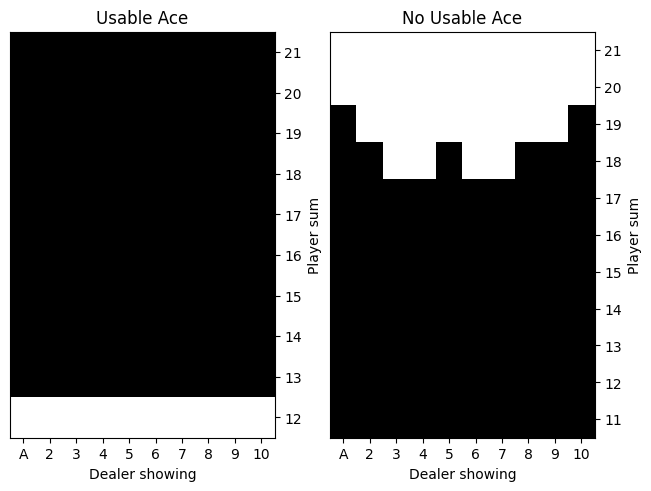

In [9]:
# use utils to plot
from helpers.utils import plotPolicy
import numpy as np

# create Q-table: [player_sum 0–21], [dealer_card 0–10], [usable_ace 0/1], [action 0/1]
Q_table = np.zeros((22, 11, 2, 2))

for state, prefs in p.items():
    if not (isinstance(state, tuple) and len(state) == 3):
        continue
    player_sum, dealer_card, usable_ace = state
    if 0 <= player_sum <= 21 and 0 <= dealer_card <= 10:
        ace = int(usable_ace)
        Q_table[player_sum, dealer_card, ace] = prefs  # prefs should be [v_stick, v_hit]

# plot
plotPolicy(Q_table)
